In [1]:
import os
import sys

import pickle

import pandas as pd
import numpy as np
import datetime
from dateutil.relativedelta import relativedelta
import sklearn.preprocessing as skp

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms
import arch.unitroot as au
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
py.init_notebook_mode(connected=True)

/opt/anaconda3/envs/crypto-env/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
from TCC_pkg import dataanalysis as da
from TCC_pkg import testspecification as tspec
from TCC_pkg import autoregressive as ar

## Load data

In [3]:
# coffee, dji, gold, ibov, nasdaq, real_peso, real_usd, sp500_fut
series_name = 'bitcoin'
with open('../Data/{}.pkl'.format(series_name), 'rb') as f:
    df_raw = pickle.load(f)

## Initial summary of data

In [4]:
df = df_raw.copy()
print('Shape: {}\n'.format(df.shape))
print('Indices: \n{}\n{}\n'.format(df.index[:5], df.index[-5:]))
print('Columns: \n{}\n'.format(df.columns))
print('Describe(): \n{}\n'.format(df.describe()))

Shape: (1986, 8)

Indices: 
DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05'],
              dtype='datetime64[ns]', name='Date', freq='D')
DatetimeIndex(['2018-06-05', '2018-06-06', '2018-06-07', '2018-06-08',
               '2018-06-09'],
              dtype='datetime64[ns]', name='Date', freq='D')

Columns: 
Index(['Close', 'High', 'Low', 'Open', 'Volume', 'Volume_USD',
       'Weighted_Price', 'Direction'],
      dtype='object')

Describe(): 
              Close          High           Low          Open         Volume  \
count   1986.000000   1986.000000   1986.000000   1986.000000    1986.000000   
mean    1758.761742   1821.568013   1677.260431   1755.005805   22541.695620   
std     3218.708731   3357.942214   3036.038758   3216.462844   20198.132461   
min       13.090000     13.150000     12.770000     13.090000     453.563089   
25%      248.523125    254.764101    242.851105    248.193862    9307.072111   
50%      476.625002

## Plot data

In [5]:
df = df_raw
da.plotscatter(df=df[['Close']], name='{}'.format(series_name), title='{}'.format(series_name))

# <span style='color:crimson'>2.</span> Preprocessing

## <span style='color:MediumBlue'>2.1.</span> Adjusting values

In [6]:
# Adjust time-series
df = df_raw.copy()

# 1. Find zeros or negative values
print('Number of zero-values: {}'.format(df[df==0].count().values))

# 2. Find NaNs
print('Number of NaNs: {}'.format(df[df.isna().values].count().values))

# 3. Eliminate entries with NaNs
df = df.dropna(how='any', axis=0)

# 4. Gaps
date_gaps = np.array([(df.index[i]-df.index[i-1]).days for i in range(1,len(df.index))])
print('Average gap: {}'.format(date_gaps.mean()))
print('Max gap: {}'.format(date_gaps.max()))
print('No. of gaps greater than 5: {}'.format(len(date_gaps[date_gaps>5])))
print('15 greatest gaps: {}'.format(np.sort(date_gaps)[-15:]))
print('Dates of greatest gap: \n{}\n'.format(df.iloc[date_gaps.argmax()-1:date_gaps.argmax()+3]))

df_adj = df

Number of zero-values: [0 0 0 0 0 0 0 0]
Number of NaNs: [1 1 1 1 1 1 1 0]
Average gap: 1.0
Max gap: 1
No. of gaps greater than 5: 0
15 greatest gaps: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Dates of greatest gap: 
Empty DataFrame
Columns: [Close, High, Low, Open, Volume, Volume_USD, Weighted_Price, Direction]
Index: []



## <span style='color:MediumBlue'>2.2.</span> Visual analysis

### Outliers

In [7]:
df = df_adj
ts = df_adj['Close']
n_std = 3

df = pd.concat([df, da.roll_stats(ts=ts, window=30)], axis=1).dropna(how='any',axis=0)
df['Upper'] = df['Rolling Mean'] + n_std*df['Rolling Variance'].apply(np.sqrt)
df['Lower'] = df['Rolling Mean'] - n_std*df['Rolling Variance'].apply(np.sqrt)

da.plotscatter(df.drop(columns='Direction'))

# Outlier criterion
df_out = df[(df['Close'] > df['Upper']) | (df['Close'] < df['Lower'])]
df['Out'] = df.loc[df_out.index, 'Close']

df = df.replace(np.nan, 0) # for plotting
da.plotscatter(df.drop(columns='Direction'))

df = df.drop(df_out.index)
df_adj_noout = df[['Close']]

### Stationarity tests

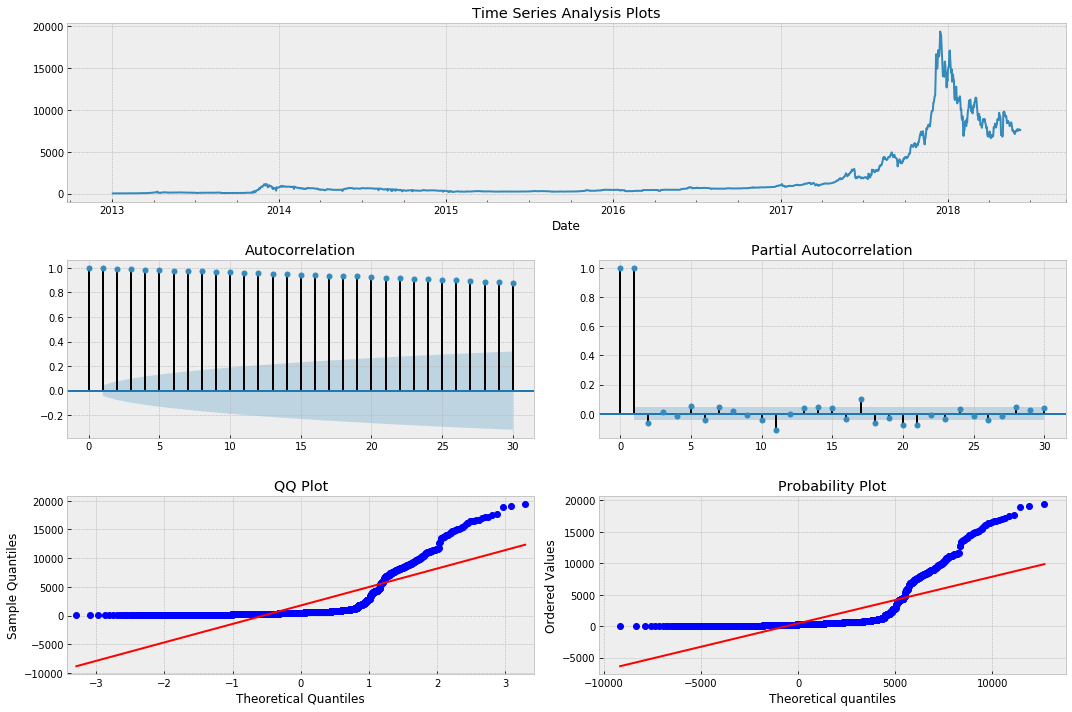

In [8]:
ts = df_adj['Close']

rolling_stats = da.roll_stats(ts=ts, window=30)
da.plotscatter(rolling_stats)
da.tsplot(ts, lags=30)

In [9]:
ts = df_adj['Close']

# Try to confirm stationarity
da.test_unitroot_adf(ts=ts)
da.test_unitroot_phillips_perron(ts=ts)

# Try to confirm unit-root
da.test_stationarity_kpss(ts=ts)

   Augmented Dickey-Fuller Results   
Test Statistic                 -1.044
P-value                         0.737
Lags                               90
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

-----------------------------------------------------

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -1.319
P-value                         0.620
Lags                               26
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

-----------------------------------------------------

    KPSS Stationarity Test Results   
Test Statistic                  3.369
P-value                         0.000
Lags                               2

## <span style='color:MediumBlue'>2.3.</span> Transformations

### <span style='color:Goldenrod'>2.3.1</span> Log-transform

In [10]:
df = df_adj[['Close']]

# Log-transform

df_log = pd.concat([df.applymap(np.log), df_adj[['Direction']]], axis=1)

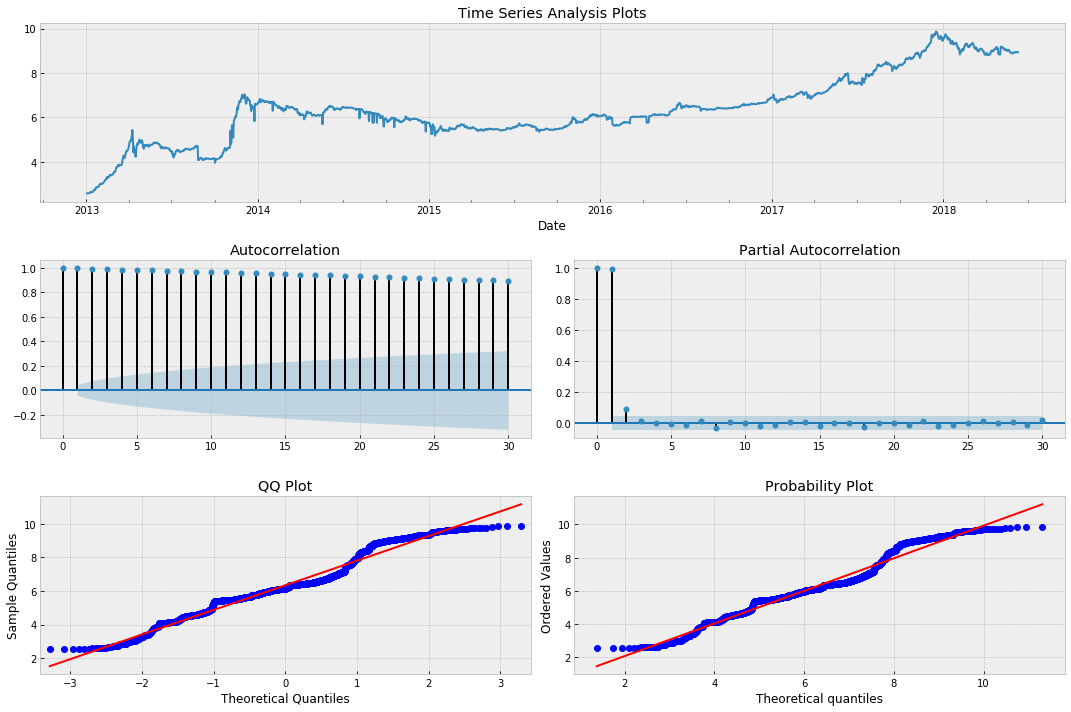

In [11]:
ts = df_log['Close']

rolling_stats = da.roll_stats(ts=ts, window=30)
da.plotscatter(rolling_stats)
da.tsplot(ts, lags=30)

In [12]:
da.plotscatter(df_log[['Close']])

In [13]:
ts = df_log['Close']

# Try to confirm stationarity
da.test_unitroot_adf(ts=ts)
da.test_unitroot_phillips_perron(ts=ts)

# Try to confirm unit-root
da.test_stationarity_kpss(ts=ts)

   Augmented Dickey-Fuller Results   
Test Statistic                 -1.877
P-value                         0.343
Lags                                7
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

-----------------------------------------------------

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -1.888
P-value                         0.338
Lags                               26
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

-----------------------------------------------------

    KPSS Stationarity Test Results   
Test Statistic                  5.197
P-value                         0.000
Lags                               2

### <span style='color:Goldenrod'>2.3.1</span> Differencing

In [14]:
df = df_log[['Close']]

df_log_diff = df_log.copy()
df_log_diff['Close'] = da.difference_ts(df=df)
df_log_diff = df_log_diff.dropna()

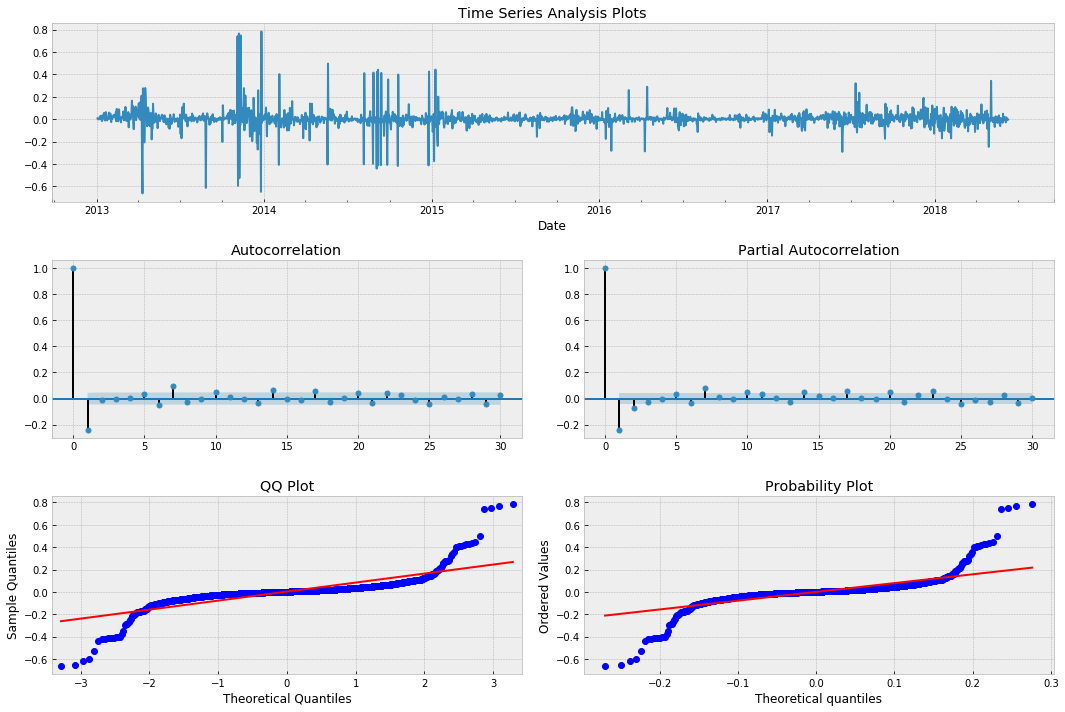

In [15]:
ts = df_log_diff['Close']

rolling_stats = da.roll_stats(ts=ts, window=30)
da.plotscatter(df_log_diff[['Close']], title='Log-retornos do Bitcoin', yaxis='Log-retornos')
da.tsplot(ts, lags=30)

In [16]:
ts = df_log_diff['Close']

# Try to confirm stationarity
da.test_unitroot_adf(ts=ts)
da.test_unitroot_phillips_perron(ts=ts)

# Try to confirm unit-root
da.test_stationarity_kpss(ts=ts)

   Augmented Dickey-Fuller Results   
Test Statistic                -16.437
P-value                         0.000
Lags                                6
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

-----------------------------------------------------

     Phillips-Perron Test (Z-tau)    
Test Statistic                -55.920
P-value                         0.000
Lags                               26
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

-----------------------------------------------------

    KPSS Stationarity Test Results   
Test Statistic                  0.140
P-value                         0.421
Lags                               2

# <span style='color:crimson'>3.</span> Data fitting

In [17]:
# Defines the input
df_input = df_log_diff.copy()

In [18]:
# Which prediction function applies to which data
diff_pred_func = lambda df: df.apply(np.sign)
classification_functions_dict = {'coffee':diff_pred_func, 'gold':diff_pred_func, 'dji':diff_pred_func,
                                 'ibov':diff_pred_func, 'nasdaq':diff_pred_func, 'real_usd':diff_pred_func,
                                 'real_peso':diff_pred_func, 'sp500_fut':diff_pred_func,  
                                 'bitcoin':diff_pred_func
                                }

In [20]:
np.random.seed(12)
test_spec = tspec.TestSpec(indices=df_input.index, 
                     start_dates=['2017-01', '2017-05', '2017-09', '2018-01'], 
                     window_size=400
                    )


In [21]:
ar_res = {}
ar_res['ARMA'] = ar.execute_test_routine(series_name,
                                      df_input, 
                                      test_spec,
                                      classification_functions_dict['{}'.format(series_name)]
                                     )
autoregressive_results = pd.DataFrame(data=ar_res)
autoregressive_results



 365
91: 

/opt/anaconda3/envs/crypto-env/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1042: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/opt/anaconda3/envs/crypto-env/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



aic: 415.99 | order: (2, 0, 3)
187: aic: 756.68 | order: (2, 0, 3)
365: aic: 1343.66 | order: (2, 0, 3)
1984: aic: 1343.66 | order: (2, 0, 3)


 379
91: aic: 418.45 | order: (2, 0, 3)
187: aic: 756.58 | order: (3, 0, 2)
365: aic: 1347.01 | order: (2, 0, 3)
1984: aic: 1384.19 | order: (2, 0, 3)


 393
91: aic: 417.90 | order: (2, 0, 3)
187: aic: 753.62 | order: (1, 0, 3)
365: aic: 1346.92 | order: (2, 0, 3)
1984: aic: 1421.29 | order: (2, 0, 3)


 407
91: aic: 359.32 | order: (0, 0, 1)
187: aic: 763.03 | order: (2, 0, 3)
365: aic: 1364.61 | order: (2, 0, 3)
1984: aic: 1477.51 | order: (2, 0, 3)


 421
91: aic: 341.22 | order: (0, 0, 1)
187: aic: 763.15 | order: (3, 0, 3)
365: aic: 1366.46 | order: (2, 0, 3)
1984: aic: 1516.85 | order: (2, 0, 3)


 435
91: aic: 330.62 | order: (0, 0, 1)
187: aic: 734.83 | order: (2, 0, 3)
365: aic: 1366.67 | order: (2, 0, 3)
1984: aic: 1555.50 | order: (2, 0, 3)


 449
91: aic: 231.37 | order: (0, 0, 1)
187: aic: 736.46 | order: (2, 0, 3)
365: aic: 1363.

1984: aic: 3470.51 | order: (0, 0, 1)


 1121
91: aic: 185.23 | order: (0, 0, 1)
187: aic: 278.00 | order: (3, 0, 3)
365: aic: 411.81 | order: (3, 0, 3)
1984: aic: 3517.77 | order: (0, 0, 1)


 1135
91: aic: 160.88 | order: (0, 0, 1)
187: aic: 276.14 | order: (3, 0, 3)
365: aic: 406.41 | order: (3, 0, 3)
1984: aic: 3548.44 | order: (0, 0, 1)


 1149
91: aic: 159.60 | order: (1, 0, 0)
187: aic: 259.93 | order: (3, 0, 3)
365: aic: 390.69 | order: (3, 0, 3)
1984: aic: 3578.87 | order: (0, 0, 1)


 1163
91: aic: 184.57 | order: (1, 0, 0)
187: aic: 300.36 | order: (0, 0, 1)
365: aic: 445.53 | order: (3, 0, 3)
1984: aic: 3617.13 | order: (0, 0, 1)


 1177
91: aic: 179.78 | order: (1, 0, 0)
187: aic: 299.76 | order: (0, 0, 1)
365: aic: 432.02 | order: (2, 0, 3)
1984: aic: 3646.72 | order: (0, 0, 1)


 1191
91: aic: 175.06 | order: (1, 0, 0)
187: aic: 299.16 | order: (0, 0, 1)
365: aic: 425.84 | order: (2, 0, 3)
1984: aic: 3676.06 | order: (0, 0, 1)


 1205
91: aic: 214.24 | order: (1, 0, 0)
1

187: aic: 406.62 | order: (3, 0, 3)
365: aic: 781.78 | order: (0, 0, 1)
1984: aic: 5219.15 | order: (0, 0, 1)


 1877
91: aic: 239.28 | order: (0, 0, 1)
187: aic: 417.17 | order: (3, 0, 3)
365: aic: 797.40 | order: (0, 0, 1)
1984: aic: 5253.60 | order: (0, 0, 1)


 1891
91: aic: 227.14 | order: (0, 0, 1)
187: aic: 423.62 | order: (3, 0, 3)
365: aic: 802.27 | order: (0, 0, 1)
1984: aic: 5284.65 | order: (0, 0, 1)


 1905
91: aic: 222.44 | order: (1, 0, 0)
187: aic: 415.36 | order: (1, 0, 0)
365: aic: 797.62 | order: (0, 0, 1)
1984: aic: 5315.06 | order: (0, 0, 1)


 1919
91: aic: 212.86 | order: (0, 0, 1)
187: aic: 415.71 | order: (1, 0, 0)
365: aic: 801.55 | order: (0, 0, 1)
1984: aic: 5346.27 | order: (0, 0, 1)


 1933
91: aic: 202.66 | order: (1, 0, 0)
187: aic: 417.72 | order: (1, 0, 0)
365: aic: 807.85 | order: (0, 0, 1)
1984: aic: 5375.57 | order: (0, 0, 1)


 1947
91: aic: 238.55 | order: (1, 0, 0)
187: aic: 466.10 | order: (1, 0, 0)
365: aic: 860.13 | order: (3, 0, 3)
1984: aic:

ARMA
2. Mathews_CorrCoef    0.013735
3. F-beta_0.5          0.575540
4. F1                  0.581818
5. Cohen_Kappa         0.013722
6. Precision           0.571429
7. Specificity         0.421053
8. Accuracy            0.518095
9. Recall              0.592593
FN                   121.000000
FP                   132.000000
TN                    96.000000
TP                   176.000000

In [23]:
autoregressive_results

ARMA
2. Mathews_CorrCoef    0.013735
3. F-beta_0.5          0.575540
4. F1                  0.581818
5. Cohen_Kappa         0.013722
6. Precision           0.571429
7. Specificity         0.421053
8. Accuracy            0.518095
9. Recall              0.592593
FN                   121.000000
FP                   132.000000
TN                    96.000000
TP                   176.000000

In [22]:
save_pred_path = './Predictions/{}.pkl'.format(series_name)
with open(save_pred_path, 'rb') as f:
    df = pickle.load(f)
    
df

Close  Direction  91 187 365 1984
Date                                            
2014-01-03  0.039155        1.0   1   1   1    1
2014-01-04  0.005644        1.0   1   1   1    1
2014-01-05  0.103809        1.0   1   1   1    1
2014-01-06  0.024458        1.0  -1  -1  -1   -1
2014-01-07 -0.153079       -1.0   1  -1  -1   -1
2014-01-08  0.037418        1.0   1   1   1    1
2014-01-09  0.015884        1.0   1   1   1    1
2014-01-10  0.011088        1.0   1   1   1    1
2014-01-11  0.056763        1.0   1   1   1    1
2014-01-12 -0.038284       -1.0  -1  -1  -1   -1
2014-01-13 -0.045682       -1.0   1   1   1    1
2014-01-14 -0.001032       -1.0   1   1   1    1
2014-01-15  0.022790        1.0   1   1   1    1
2014-01-16 -0.026222       -1.0   1   1   1    1
2014-01-17 -0.030965       -1.0   1   1   1    1
2014-01-18  0.016313        1.0   1   1   1    1
2014-01-19  0.031425        1.0   1   1   1    1
2014-01-20 -0.005573       -1.0   1  -1   1    1
2014-01-21 -0.011796       -1.0   1   1   1    1
2014-01-22 -0.002768       -1.0   1   1   1    1
2014-01-23  0.000817        1.0   1   1   1    1
2014-01-24 -0.039065       -1.0   1   1   1    1
2014-01-25  0.026676        1.0   1   1   1    1
2014-01-26  0.009140        1.0   1   1   1    1
2014-01-27 -0.067018       -1.0   1  -1   1    1
2014-01-28  0.045520        1.0   1   1   1    1
2014-01-29 -0.004085       -1.0   1   1   1    1
2014-01-30  0.009468        1.0   1  -1   1    1
2014-01-31  0.001348        1.0   1   1   1    1
2014-02-01  0.015485        1.0   1   1   1    1
...              ...        ...  ..  ..  ..  ...
2018-05-11 -0.069739       -1.0   1   1   1    1
2018-05-12  0.007980        1.0   1  -1   1    1
2018-05-13  0.025452        1.0   1   1   1    1
2018-05-14 -0.002444       -1.0  -1   1   1   -1
2018-05-15 -0.023263       -1.0   1   1   1    1
2018-05-16 -0.015316       -1.0   1   1   1    1
2018-05-17 -0.034249       -1.0   1   1   1    1
2018-05-18  0.021816        1.0  -1   1   1    1
2018-05-19 -0.000663       -1.0  -1   1   1   -1
2018-05-20  0.033801        1.0  -1   1   1    1
2018-05-21 -0.014632       -1.0  -1   1   1   -1
2018-05-22 -0.049672       -1.0  -1   1   1    1
2018-05-23 -0.062560       -1.0  -1  -1   1    1
2018-05-24  0.010084        1.0  -1  -1   1    1
2018-05-25 -0.015261       -1.0  -1   1   1    1
2018-05-26 -0.017527       -1.0  -1   1   1    1
2018-05-27  0.000905        1.0  -1   1   1    1
2018-05-28 -0.031973       -1.0  -1   1   1    1
2018-05-29  0.048494        1.0  -1   1   1    1
2018-05-30 -0.011747       -1.0  -1   1   1   -1
2018-05-31  0.014892        1.0  -1   1   1    1
2018-06-01  0.003524        1.0  -1  -1   1    1
2018-06-02  0.016245        1.0  -1  -1   1    1
2018-06-03  0.009502        1.0  -1  -1   1   -1
2018-06-04 -0.028889       -1.0  -1  -1   1    1
2018-06-05  0.016895        1.0  -1  -1   1    1
2018-06-06  0.005141        1.0  -1  -1   1    1
2018-06-07  0.003710        1.0  -1  -1   1    1
2018-06-08 -0.009004       -1.0  -1  -1   1    1
2018-06-09 -0.002657       -1.0  -1  -1   1    1

[1619 rows x 6 columns]

## <span style='color:MediumBlue'>3.1.</span> ARMA model selection

### <span style='color:Goldenrod'>3.1.1</span> Pre-select with AIC

## <span style='color:MediumBlue'>3.2.</span> Fitting and refinement

### <span style='color:Goldenrod'>3.1.2</span> Confidence/significance refinement

### <span style='color:Goldenrod'>3.1.3</span> Final selection with Validation Set

## <span style='color:MediumBlue'>3.3.</span> Residual Analysis

### <span style='color:Goldenrod'>3.3.1</span> ARCH effects

### <span style='color:Goldenrod'>3.3.2</span> Serial correlation of residuals

## <span style='color:MediumBlue'>3.4.</span> GARCH model selection

## <span style='color:MediumBlue'>3.5.</span> Fitting

## <span style='color:MediumBlue'>3.6.</span> Standardized Residual Analysis

### <span style='color:Goldenrod'>3.6.1</span> Serial correlation of residuals

# <span style='color:crimson'>4.</span> Testing: One-step-ahead Forecasting

## <span style='color:MediumBlue'>3.1.</span> Iterative

## <span style='color:MediumBlue'>3.1.</span> Daily remodeling

O que precisa ter:
- janela de tempo - quantos dias consideraremos para o modelo?
    - isso pode ser feito utilizando todo o dataset com intervalos randomicos
- 'stride' - saltos de quantos dias ate novo modelo?
    - tambem pode ser estimado com todo o dataset e intervalos randomicos
- Funcoes
    - Tirar log
    - Diferenciar
    - Testes estatisticos
    - Encontrar melhor modelo
    - Predizer (1 dia a frente ou varios)